<table style="width:100%">
  <tr>
    <td><img src="./img/logo_EPM_UNIOVI_CabeceroWEB.gif" width="211" height="69" alt="Uniovi & EP Mieres logos" title="Uniovi & EP Mieres logos" /></td>
    <td><font color=brown>Procesamiento de imágenes <br> de Sensores Aerotransportados y Satélite<br></font>
    <font color=green>Universidad de Oviedo. <br>Ingeniería en Geomática</font> <br><br>sgcortes@uniovi.es</td>
  </tr>
</table>

## Superimposición imagen térmica y visible
Las imágenes térmica y visible capturadas por el dron que está desarrolando LOCIS provienen de cámaras diferentes y tienen distintos parámetros internos (focal, resolución ,distorión). Además los sensores térmico y visible también están situados en lugares ligeramente deiferentes por motivos de espacio físico dentro del gimbal.

![montura giroestabilizada](GimbalGeminiFRONT2.png) 

## Características de las cámaras:
De los datos suminsitrados por LOCIS y la página web del fabricante de la montura, el sensor, las especificaciones técnicas de las cámaras y los cabeceros EXIF de las imágenes, ha sido posible extraer los datos **genéricos** siguientes:

* Cámara térmica FLIR VUE PRO 640: Resol. 640x512, Focal: 13 mm, Pixel pitch: 17 micras
* Cámara visible: Basada en sensor [SONY IMX206 sensor ]. Resol. 4608x3456 Focal: 5 mm, Pixel Pitch: 1.34 x 1.34 micras 



* [Dronebase.it Gemini mount](https://www.dronebase.it/prodotto/dual-sensor-ir-eo-gimbal-gemini-ir-2/).
* [SONY IMX206 sensor ](http://www.camera-module.com/product/mipicameramodule/16mp-mipi-camera-module-sony-imx206-sensor.html)

Con estos datos trataremos de implementar la superimposición de ambos tipos de imágenes.




## Carga librerías y datos iniciales


In [10]:
import skimage
import skimage.io as io
import matplotlib.pyplot as plt
import numpy as np
import math
import glob
import os

# %% Focales y píxeles   
f_th = 13.25 # mm
f_rgb = 4.5 # mm
     
Ps_rgb = 1.34 # micras
Ps_th = 17. # micras

#### Cálculo de factores de conversión tamaño píxel y focales
El proceso consistirá en escalar la imagen térmica hasta la distancia focal de la visible, aumentar la resolución de la imagen térmica para igualarla con la visible y 
finalmente superimponer ambas. Se tendrán en cuenta las separaciones (horizontal y vertical) entre los ejes de ambas cámaras. 
![Doble Cámara](FLIR_THERMAL2.jpg) 

In [13]:
x_foc = f_rgb/f_th
x_pix = Ps_th/Ps_rgb
# Correcciones vertical y horizontal por desplazamiento de los ejes ópticos en la montura
Cv = 110
Ch =-20        

#### Lectura de imágenes
Las imágenes térmicas y visibles se entiende que se encuentran en directorios `Termica` y `RGB` que cuelgan del directorio actual en el que está este script. 

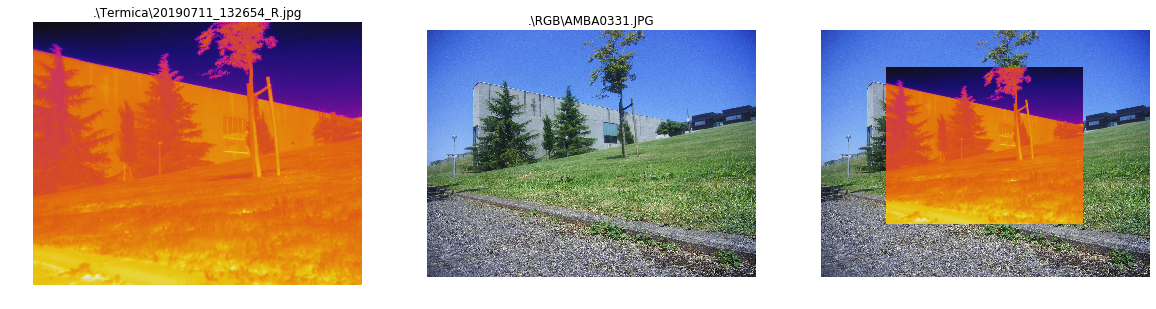

./superimposed/20190711_132654_RAMBA0331.JPG


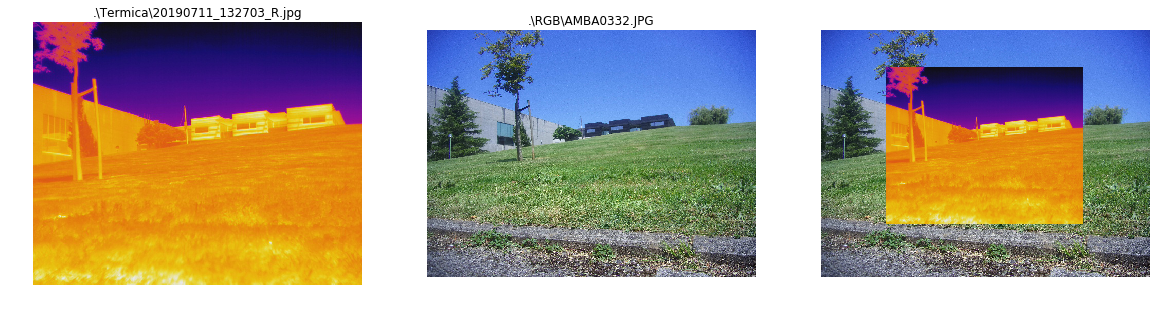

./superimposed/20190711_132703_RAMBA0332.JPG


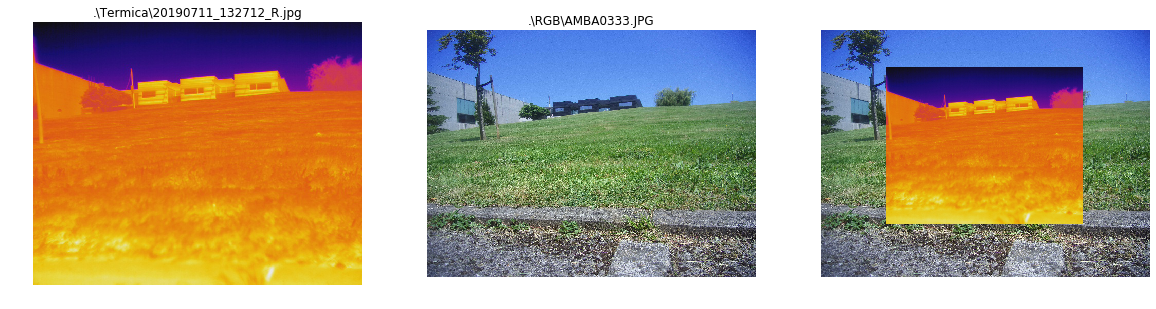

./superimposed/20190711_132712_RAMBA0333.JPG


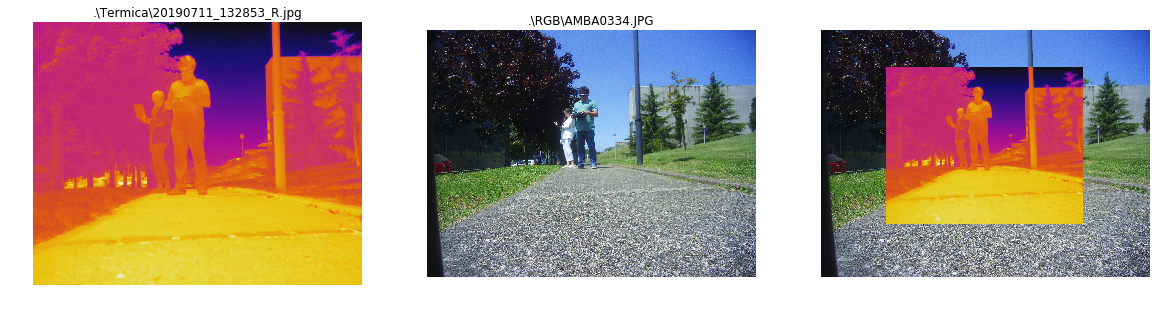

./superimposed/20190711_132853_RAMBA0334.JPG


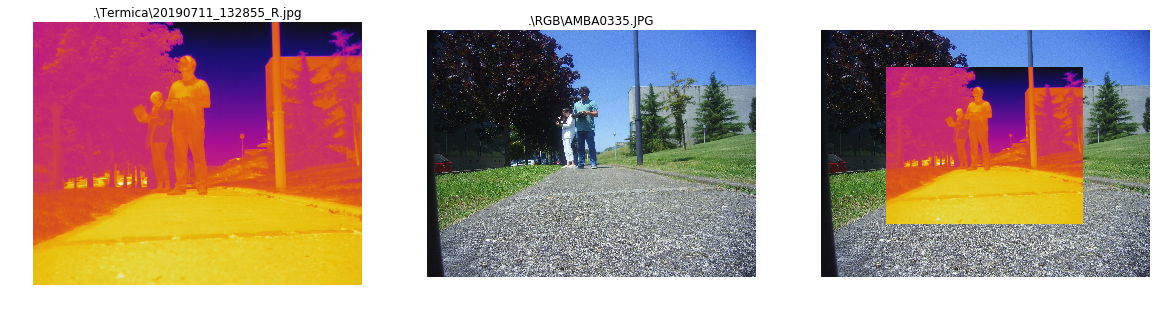

./superimposed/20190711_132855_RAMBA0335.JPG


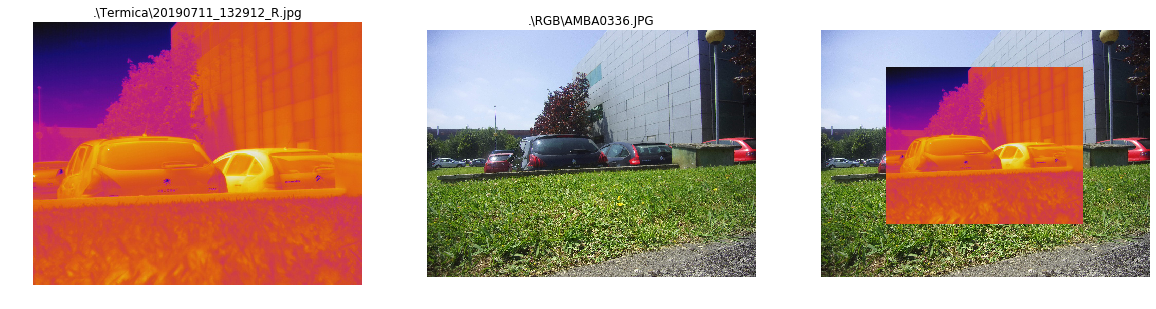

./superimposed/20190711_132912_RAMBA0336.JPG


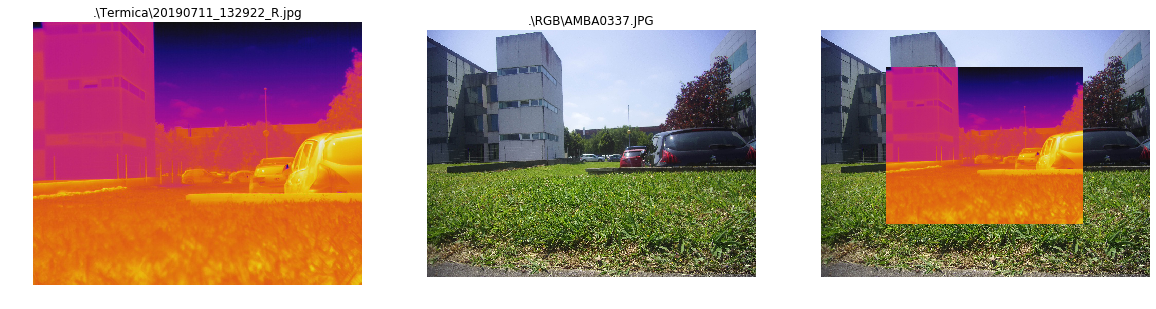

./superimposed/20190711_132922_RAMBA0337.JPG


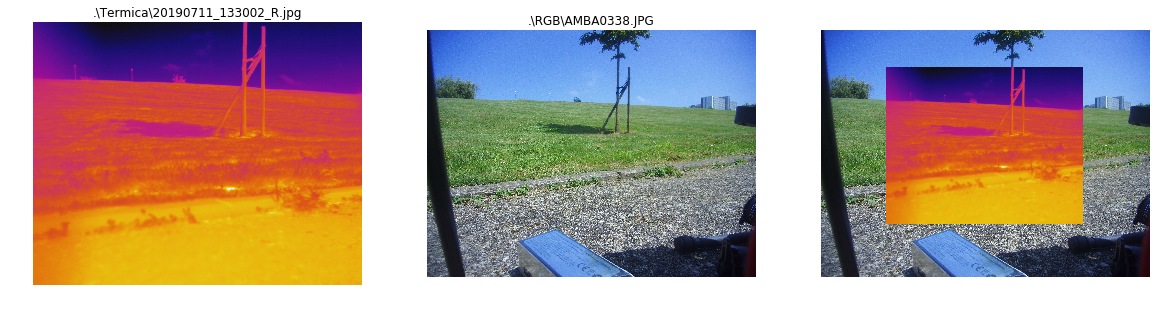

./superimposed/20190711_133002_RAMBA0338.JPG


In [14]:
termicas = glob.glob(".\Termica\*.jpg")
visibles = glob.glob(".\RGB\*.jpg")

for rt in zip(visibles, termicas):
        
        th = io.imread(rt[1])
        plt.figure(figsize=(20,20))
        plt.subplot(131)
        plt.imshow(th);
        plt.title(rt[1])
        plt.axis('off')
        
        # %% IMAGEN VISIBLE
        rgb = io.imread(rt[0])   
        plt.subplot(132)
        plt.imshow(rgb);
        plt.title(rt[0])
        plt.axis('off')
       
        # %% COBERTURA SENSOR TERMICO sobre senor RGB
        
        size_th = th.shape[0:2] # pixeles termicos
        sizeTh_rgb = np.floor(np.float32(size_th) * x_foc *x_pix)
                
        # %% IMAGEN TÉRMICA ESCALADA
        scale = sizeTh_rgb[0]/th.shape[0]
        th_sc = skimage.transform.rescale(th, scale,multichannel=True)
        
        # %% limites de intervalos pixeles
        rgb_center = np.float32(rgb.shape[0:2])/2.
        # indice del pixel central
        rgb_center = [round(rgb_center[0]),round(rgb_center[1])]
                
        # límites en coords pixel de la ventana térmica sobre la RGB
        if sizeTh_rgb[0] % 2 == 0:
            Dh = sizeTh_rgb[0] / 2 
            botpixfil = rgb_center[0]-Dh
        elif sizeTh_rgb[0] % 2 != 0:
            Dh = math.floor(sizeTh_rgb[0] / 2) 
            botpixfil = rgb_center[0]-(Dh+1)    
        
        if sizeTh_rgb[1] % 2 == 0:
            Dw = np.floor(sizeTh_rgb[1] / 2) 
            leftpixcol = rgb_center[1]-Dw
        elif sizeTh_rgb[1] % 2 != 0:
            Dw = math.floor(sizeTh_rgb[1] / 2) 
            leftpixcol = rgb_center[1]-(Dw+1)
            
        # Correcciones horizontal y vertical
        # Tienen en cuenta el desplazamiento en vertical y horizontal de los
        # ejes ópticos de las cámaras. Las unidades son píxels de la RGB
        # dividir entre 1.34 micras para pasar a uds absolutas.
        
        botpixfil -= Cv
        leftpixcol += Ch 
        #
        # %% SUPERPOSICION IMAGENES
        rgb_th=skimage.img_as_float(rgb.copy())
        rgb_th[int(botpixfil):int(botpixfil)+th_sc.shape[0],int(leftpixcol):int(leftpixcol)+th_sc.shape[1],:]=th_sc
        
        plt.subplot(133)
        plt.imshow(rgb_th)
        plt.axis('off')
        plt.show()
        
        # %% Grabar imagen visible-termica superpuesta
        # nombre termica
        headth, tailth = os.path.split(rt[1])
        id = tailth.find(".")
        tailth = tailth[0:id]
        headrgb, tailrgb = os.path.split(rt[0])
        filename = ["./superimposed/"+ tailth + tailrgb]
        print(filename[0])
        io.imsave(filename[0], skimage.img_as_ubyte(rgb_th))

La imágenes finales se escriben como ficheros con nombre formado por el nombre de las dos imágenes componentes en el subdirectorio `superimposed`